In [1]:
import pandas as pd
import requests
# para extrair informações de páginas HTML
import bs4
from bs4 import BeautifulSoup

# utilizada para nos indicar o caminho do executável do Python
import sys

# Controlar espera entre requisições
import time
# Renderizar HTML
import IPython

import os


In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains


### Criando um driver

Execute a linha abaixo. Você irá perceber que será criada uma janela do navegador Chrome. Deixe esta janela aberta.

In [3]:
PROXY = "117.250.3.58:8080"
chrome_options = webdriver.ChromeOptions()
user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
chrome_options.add_argument(f'user-agent={user_agent}')
#chrome_options.add_argument('--proxy-server=%s' % PROXY)
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
driver.set_page_load_timeout(60)


### Selecione os aeroportos de origem e destino

In [4]:
aeroporto_origem = 'Curitiba'
aeroporto_destino = 'Fortaleza'

# Começar o Web Scrapping


### Selecionar a url e abrir o site

In [5]:
url = "https://www.voegol.com.br/"

# Abrir o site da Decolar
driver.get(url)
time.sleep(5)

In [6]:
rejeitar_cookies = driver.find_element(By.XPATH, '//*[@id="onetrust-reject-all-handler"]')
rejeitar_cookies.click()

Selecionar trecho apenas de ida.

In [7]:
trecho_unico = driver.find_element(By.XPATH, '//*[@id="edit-fieldset-route-type"]')
trecho_unico.click()

ida_ou_volta = driver.find_element(By.XPATH, '//*[@id="edit-fieldset-route-type-options"]/div/div[2]/label')
ida_ou_volta.click()

### Digitar nossa origem na barra de pesquisa

In [8]:
barra_origem = driver.find_element(By.XPATH, "//*[@id='select2-edit-origin-container']")
ActionChains(driver).click(barra_origem).perform()



# Esperar até que a barra de pesquisa esteja disponível
search_bar_origem = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.XPATH, "//*[@id='edit-fieldset-origin']/div/span[1]/span[1]/span[1]/input"))
)


# Limpar o campo de origem e inserir aeroporto origem
#search_bar_origem.clear()
#time.sleep(1)

# Clicar na barra de pesquisa
ActionChains(driver).click(search_bar_origem).perform()
time.sleep(1)

# Limpar a barra de pesquisa (CTRL+A e DELETE)
ActionChains(driver).key_down(Keys.CONTROL).send_keys("a").key_up(Keys.CONTROL).send_keys(Keys.DELETE).perform()
time.sleep(1)

# Digitar "Curitiba" na barra de pesquisa
ActionChains(driver).send_keys_to_element(search_bar_origem, aeroporto_origem).perform()
time.sleep(1)

# Pressionar Enter
ActionChains(driver).send_keys(Keys.ENTER).perform()
time.sleep(1)

### Digitar nosso destino na barra de pesquisa

In [9]:
barra_destino = driver.find_element(By.XPATH, "//*[@id='select2-edit-destiny-container']")
ActionChains(driver).click(barra_destino).perform()
time.sleep(1)

search_bar_destino = driver.find_element(By.XPATH, "//*[@id='edit-fieldset-destiny']/div[1]/span[1]/span[1]/span[1]/input")

ActionChains(driver).click(search_bar_destino).key_down(Keys.CONTROL).send_keys("a").key_up(Keys.CONTROL).send_keys(Keys.DELETE).perform()
ActionChains(driver).send_keys_to_element(search_bar_destino, aeroporto_destino).perform()
time.sleep(1)
ActionChains(driver).send_keys(Keys.ENTER).perform()
time.sleep(1)

### Selecionar Data de partida e retorno


# Selecionar as datas

In [10]:
escolher_ida = driver.find_element(By.XPATH, "//*[@id='edit-departure-date']")
escolher_ida.click()

time.sleep(3)

# 17/06/2024
data_partida_selector = driver.find_element(By.XPATH, "//*[@id='datepicker-calendar']/div/div[2]/table/tbody/tr[4]/td[2]/a")
data_partida_selector.click()

In [11]:
botao_aplicar = driver.find_element(By.XPATH, "//*[@id='ticket-search-submit']")
botao_aplicar.click()

Codigo acima funciona! mas precisa ver como fazer para que um input digitado ache a data correta no Xpath

In [12]:
dia_da_semana = 'Sexta-feira'
time.sleep(10)
preco_elements = driver.find_elements(By.XPATH, "//*[contains(@id, 'lbl_priceValue_') and contains(@id, '_emission')]")
origem_elements = driver.find_elements(By.XPATH, "//*[contains(@id, 'lbl_origin_') and contains(@id, '_emission')]")
destino_elements = driver.find_elements(By.XPATH, "//*[contains(@id, 'lbl_destination_') and contains(@id, '_emission')]")

# Extrair os valores dos preços para sexta-feira e converter para float
precos = [float(element.text.replace('R$', '').replace('.', '').replace(',', '.')) for element in preco_elements if element.text.strip()]

# Calcular o preço mais barato e o preço médio para sexta-feira
preco_minimo_sexta = min(precos) if precos else None
preco_medio_sexta = sum(precos) / len(precos) if precos else None
# Caminho do arquivo Excel
excel_file = 'precos_voos.xlsx'

# Verificar se o arquivo Excel existe
if os.path.isfile(excel_file):
    # Carregar o arquivo Excel existente
    df_existing = pd.read_excel(excel_file, index_col='Dia da Semana')

    # Atualizar o DataFrame existente com os novos dados
    for i in range(len(precos)):
        preco = precos[i]
        origem = origem_elements[i].text
        destino = destino_elements[i].text
        # Create a new row with the desired values
        new_row = pd.DataFrame({'Dia da Semana': [dia_da_semana], 'Origem': [origem], 'Destino': [destino], 'Preço': [preco], 'Preço Médio': [preco_medio_sexta], 'Preço Mais Barato': [preco_minimo_sexta]},index=[dia_da_semana])
        # Append the new row to the DataFrame
        df_existing = pd.concat([df_existing, new_row])
    
    # Salvar o DataFrame atualizado no arquivo Excel
    with pd.ExcelWriter(excel_file) as writer:
        df_existing.to_excel(writer)
else:
    # Salvar o DataFrame em um novo arquivo Excel
    for i in range(len(precos)):
        preco = precos[i]
        origem = origem_elements[i].text
        destino = destino_elements[i].text
        # Create a new row with the desired values
        if i==0:
            df_existing = pd.DataFrame({'Dia da Semana': [dia_da_semana], 'Origem': [origem], 'Destino': [destino], 'Preço': [preco], 'Preço Médio': [preco_medio_sexta], 'Preço Mais Barato': [preco_minimo_sexta]})
        else:
            new_row = pd.DataFrame({'Dia da Semana': [dia_da_semana], 'Origem': [origem], 'Destino': [destino], 'Preço': [preco], 'Preço Médio': [preco_medio_sexta], 'Preço Mais Barato': [preco_minimo_sexta]})
            # Append the new row to the DataFrame
            df_existing = pd.concat([df_existing, new_row], ignore_index=True)

    with pd.ExcelWriter(excel_file) as writer:
        df_existing.to_excel(writer)


### Analise descritiva



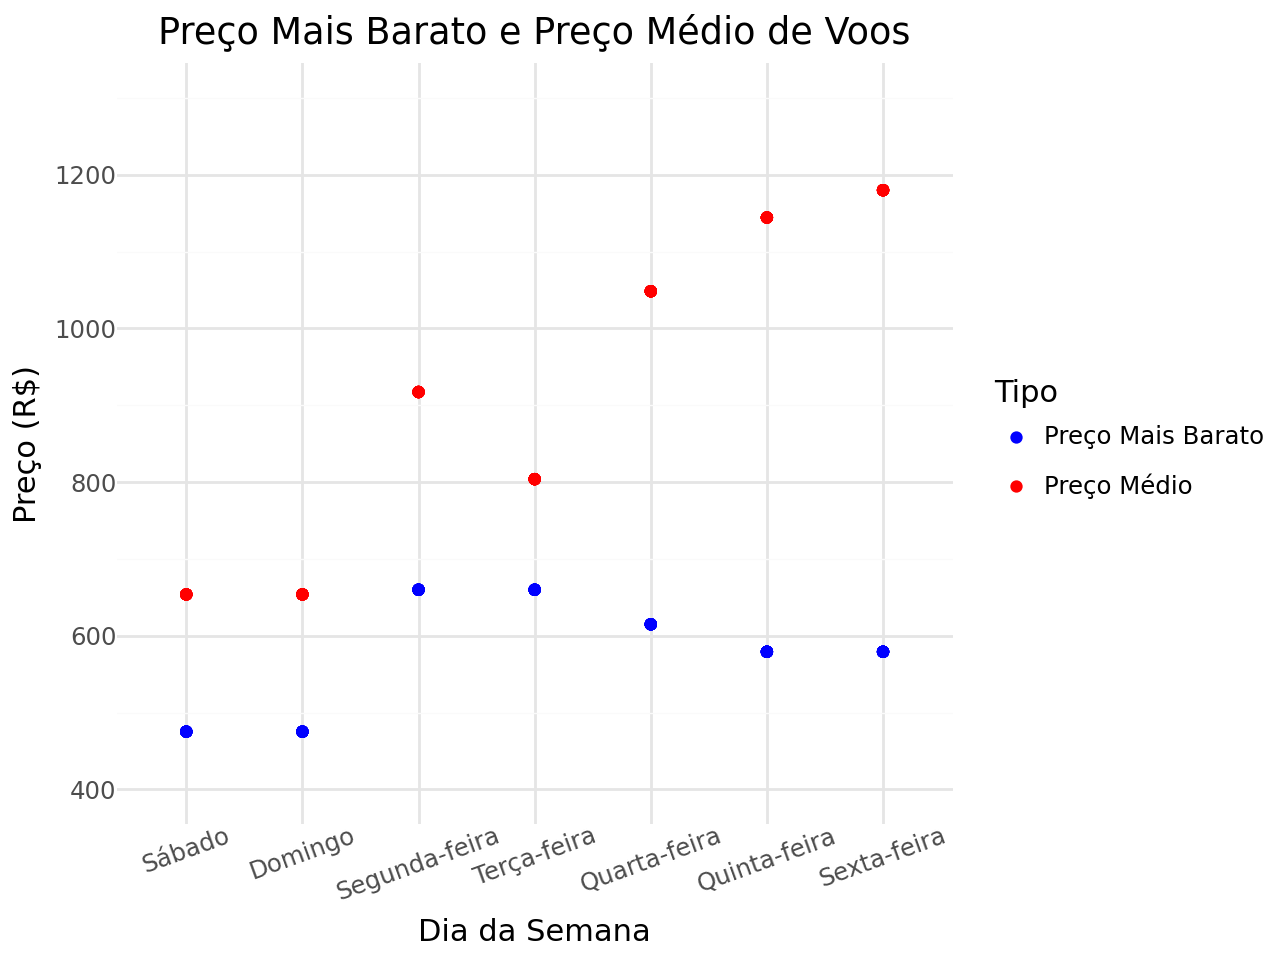

In [10]:
from plotnine import *

# Carregar o arquivo Excel
excel_file = 'precos_voos.xlsx'
dados = pd.read_excel(excel_file)

# Plotar o preço mais barato e media para cada dia da semana

dados_long = dados.melt(id_vars=['Dia da Semana'], value_vars=['Preço Mais Barato', 'Preço Médio'], 
                        var_name='Tipo', value_name='Preço_tipo')
dados['Rota'] = dados['Origem'] + ' - ' + dados['Destino']

media_e_mais_barato = (ggplot(dados_long, aes(x='Dia da Semana', y='Preço_tipo', color='Tipo')) +
        geom_point() +
        labs(title='Preço Mais Barato e Preço Médio de Voos', x='Dia da Semana', y='Preço (R$)', color='Tipo') +
        theme_minimal() +
        scale_x_discrete(limits=['Sábado', 'Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira']) +
        scale_y_continuous(limits=[400, 1300]) +
        theme(axis_text_x=element_text(rotation=20)) +
        scale_color_manual(values=['blue', 'red'], labels=['Preço Mais Barato', 'Preço Médio']))

media_e_mais_barato

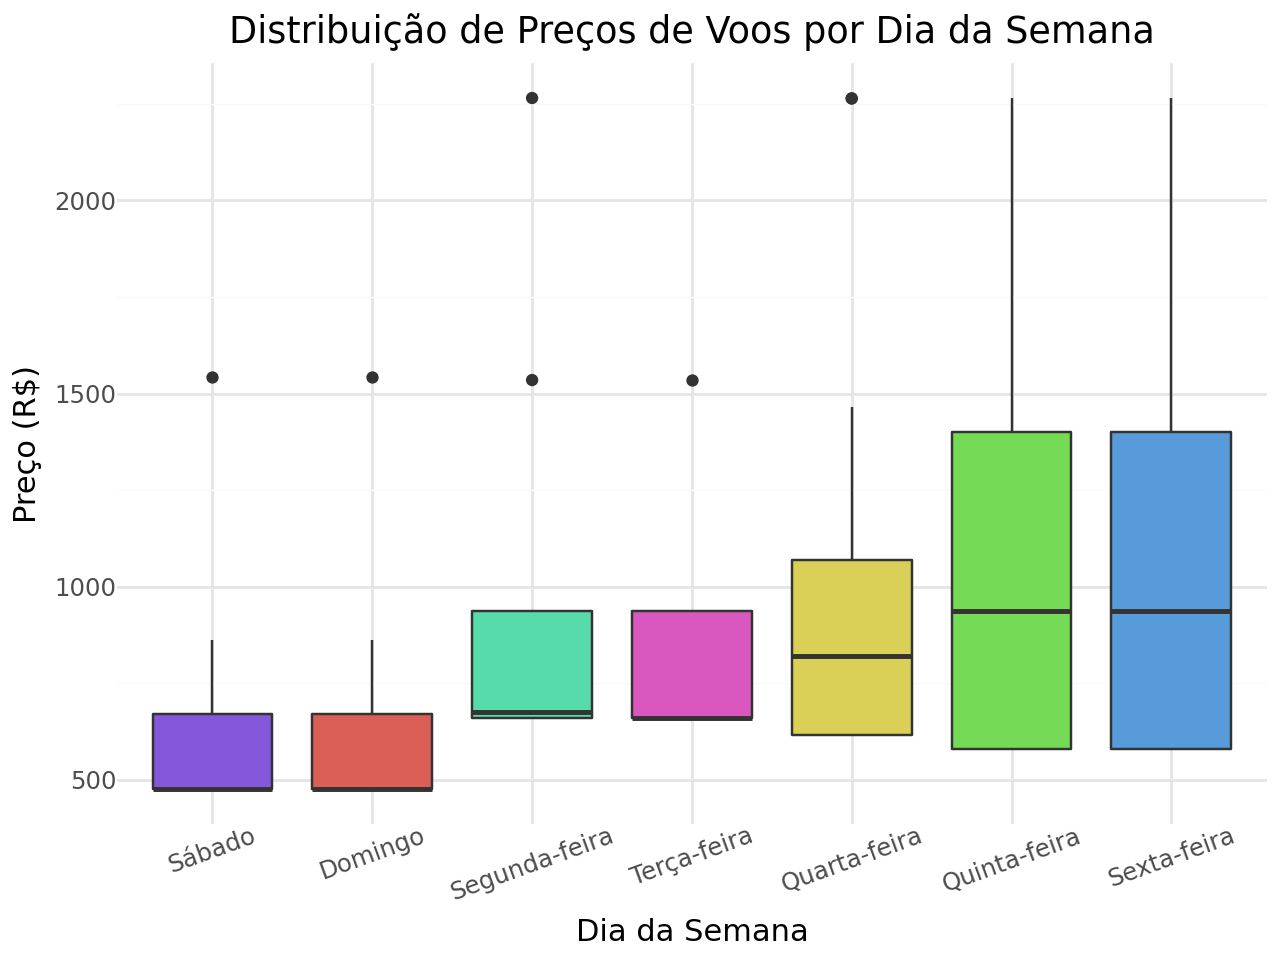

In [30]:
#Boxplot de preco por dia da semana
boxplot_preco_por_dia = (
    ggplot(dados, aes(x='Dia da Semana', y='Preço',fill='Dia da Semana')) +
    geom_boxplot() +
    labs(title='Distribuição de Preços de Voos por Dia da Semana', x='Dia da Semana', y='Preço (R$)') +
    theme_minimal() +
    scale_x_discrete(limits=['Sábado', 'Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira']) +
    theme(axis_text_x=element_text(rotation=20))+
    theme(legend_position='none')
)
boxplot_preco_por_dia

c:\Python312\Lib\site-packages\mizani\palettes.py:489: UserWarning: Warning message:Brewer palette Set3 has a maximum of 12 colors Returning the palette you asked for with that many colors


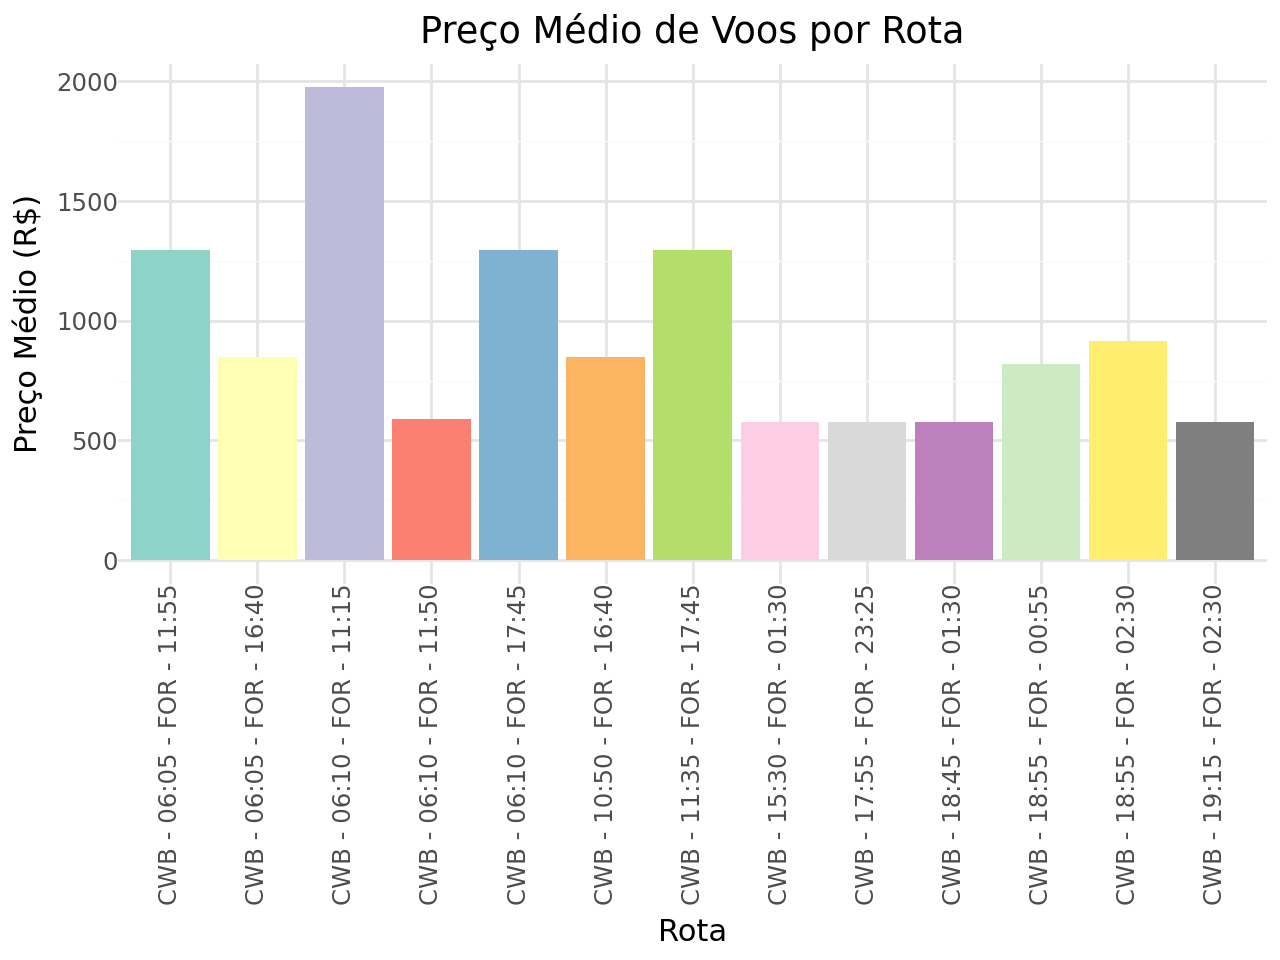

In [61]:
# Preço médio por rota
preco_medio_rota = dados.groupby(['Origem', 'Destino'])['Preço'].mean().reset_index()
preco_medio_rota['Rota'] = preco_medio_rota['Origem'] + ' - ' + preco_medio_rota['Destino']

plot_preco_medio_rota = (
    ggplot(preco_medio_rota, aes(x='Rota', y='Preço', fill='Rota')) +
    geom_col() +
    labs(title='Preço Médio de Voos por Rota', x='Rota', y='Preço Médio (R$)') +
    theme_minimal() +
    theme(axis_text_x=element_text(rotation=90)) +
    scale_fill_brewer(type='qual', palette='Set3')+
    theme(legend_position='none')
)
plot_preco_medio_rota


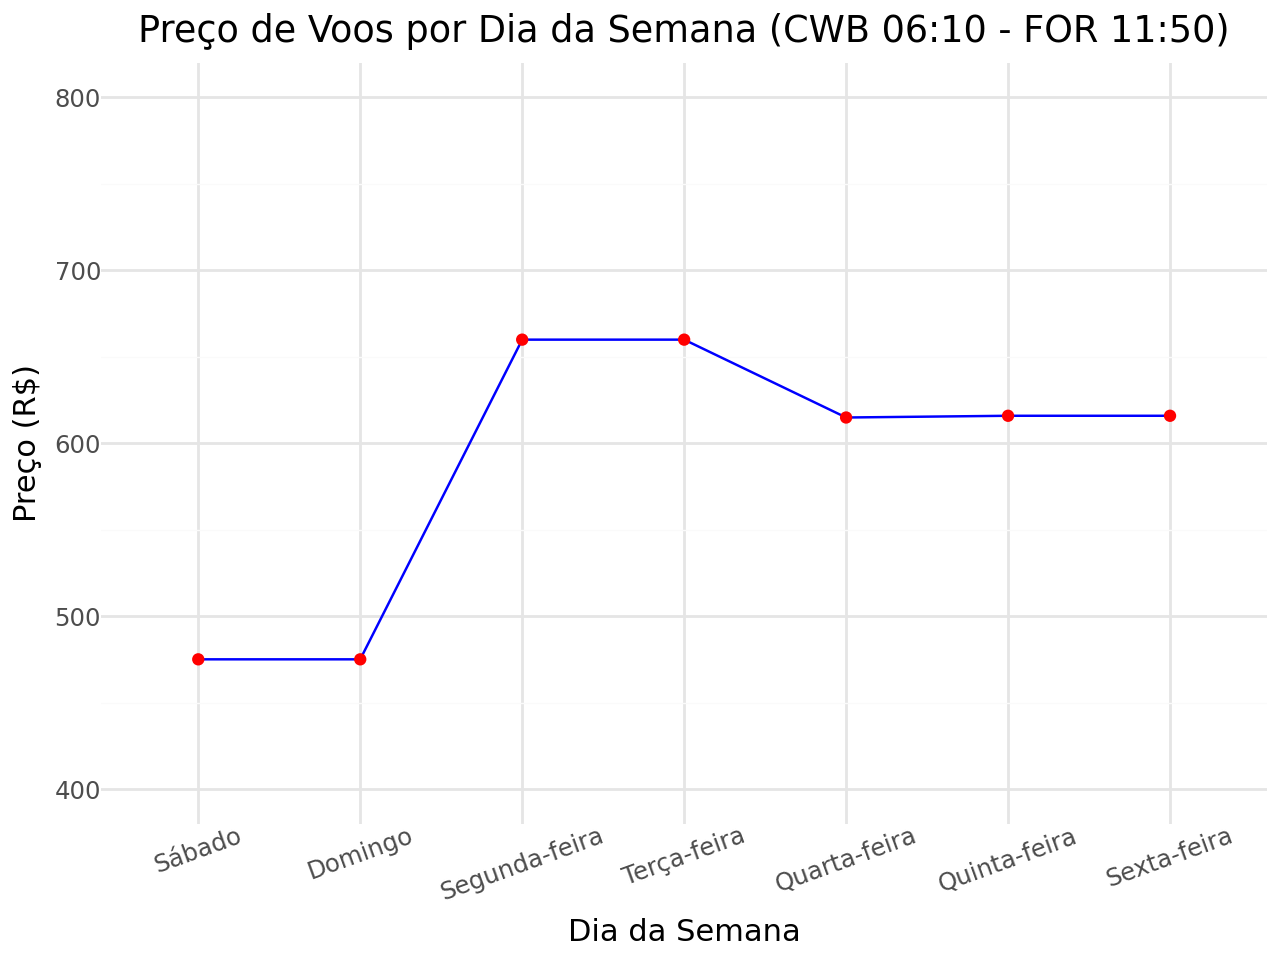

In [52]:
#Utilizar somente a rota CWB 06:10 - FOR 11:50
dados_selecionados = dados[(dados['Origem'] == 'CWB - 06:10') & (dados['Destino'] == 'FOR - 11:50')]
dados_selecionados
plot_preco_rota = (
    ggplot(dados_selecionados, aes(x='Dia da Semana', y='Preço', group=1)) +
    geom_line(color='blue') +
    geom_point(color='red') +
    labs(title='Preço de Voos por Dia da Semana (CWB 06:10 - FOR 11:50)', x='Dia da Semana', y='Preço (R$)') +
    theme_minimal() +
    scale_x_discrete(limits=['Sábado', 'Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira']) +
    scale_y_continuous(limits=[400, 800]) +
    theme(axis_text_x=element_text(rotation=20))
)
plot_preco_rota